# Centrality measures

Much of this content is based heavily on Section 7.1 from Mark Newman's "Networks"
{cite:p}`newman2018networks`. 

Lots of research has gone into studying various notions of a "how important is each node?" in 
a network. Of course, as this vague question suggests, there are many ways to define 
what we mean by important. Below, we'll cover a few of the most famous and commonly 
used notions, primarily because it will be useful to know what these terms mean when 
reading studies which use network science. Also, many of these methods are based on
elegant and relatively simple mathematics. 

## Degrees

The first notion of centrality we'll consider is the node's [**degree**](https://en.wikipedia.org/wiki/Degree_(graph_theory)), sometimes called **degree centrality**, 
though I personally won't use that term. The degree of a node is simply the number of other nodes to which it
is connected.



In [26]:
import networkx as nx
import numpy as np

g = nx.karate_club_graph()
g.degree()


DegreeView({0: 16, 1: 9, 2: 10, 3: 6, 4: 3, 5: 4, 6: 4, 7: 4, 8: 5, 9: 2, 10: 3, 11: 1, 12: 2, 13: 5, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2, 19: 3, 20: 2, 21: 2, 22: 2, 23: 5, 24: 3, 25: 3, 26: 2, 27: 4, 28: 3, 29: 4, 30: 4, 31: 6, 32: 12, 33: 17})

This output is essentially a dictionary mapping each node in the network to its degree.

Computing the degree is also quite easy with the adjacency matrix:

In [27]:
A = nx.to_numpy_array(g)
A.sum(axis=0)

array([16.,  9., 10.,  6.,  3.,  4.,  4.,  4.,  5.,  2.,  3.,  1.,  2.,
        5.,  2.,  2.,  2.,  2.,  2.,  3.,  2.,  2.,  2.,  5.,  3.,  3.,
        2.,  4.,  3.,  4.,  4.,  6., 12., 17.])

We see that the output matches, as expected. For a directed network, there are distinct 
notions of degree based on whether we are considering a node's outputs or inputs. These 
are simply termed **[out and in degree](https://en.wikipedia.org/wiki/Directed_graph#Indegree_and_outdegree)**, where
out degree is the number of outputs from a given node, and likewise for the in degree.

Let's see what this looks like to compute using `networkx` and an adjacency matrix:

In [28]:
from graspologic.datasets import load_drosophila_left
from graspologic.utils import binarize

# load a subset of this adjacency matrix as our dataset
A = load_drosophila_left()[:30, :30]
A = binarize(A)

out_degrees = A.sum(axis=1)
out_degrees


array([26., 28., 28., 28., 27., 27., 26., 28., 26., 25., 27., 27., 26.,
       25., 27., 28., 25., 25., 26., 26., 28., 27., 24., 26., 19., 24.,
       20., 23., 26., 25.])

In [29]:
in_degrees = A.sum(axis=0)
in_degrees

array([27., 26., 26., 28., 29., 28., 25., 25., 25., 26., 23., 25., 28.,
       25., 28., 27., 29., 25., 27., 29., 26., 26., 21., 25., 19., 21.,
       21., 28., 27., 28.])

In [30]:
g = nx.from_numpy_array(A, create_using=nx.DiGraph)
g.out_degree()

OutDegreeView({0: 26, 1: 28, 2: 28, 3: 28, 4: 27, 5: 27, 6: 26, 7: 28, 8: 26, 9: 25, 10: 27, 11: 27, 12: 26, 13: 25, 14: 27, 15: 28, 16: 25, 17: 25, 18: 26, 19: 26, 20: 28, 21: 27, 22: 24, 23: 26, 24: 19, 25: 24, 26: 20, 27: 23, 28: 26, 29: 25})

In [31]:
g.in_degree()

InDegreeView({0: 27, 1: 26, 2: 26, 3: 28, 4: 29, 5: 28, 6: 25, 7: 25, 8: 25, 9: 26, 10: 23, 11: 25, 12: 28, 13: 25, 14: 28, 15: 27, 16: 29, 17: 25, 18: 27, 19: 29, 20: 26, 21: 26, 22: 21, 23: 25, 24: 19, 25: 21, 26: 21, 27: 28, 28: 27, 29: 28})

## Eigenvector centrality

Our next notion of importance for each node is called **[eigenvector centrality](https://en.wikipedia.org/wiki/Eigenvector_centrality)**. The eigenvector centrality has an interesting, circular definition: nodes are considered more important if they themselves are connected to many important nodes. 

How can we write this down mathematically? Let's say that we are after a vector $x$, which 
has length $n$ (the number of nodes in our graph). Element $x_i$ in this vector will 
represent the eigenvector centrality that we are after for node $i$. Based on what we 
said about in the definition, then this means that we can write: 

$$x_i = c \sum A_{ij} x_j$$

How does this work? For any potential edge incident to $i$ that doesn't exist, $A_{ij} = 0$, 
and thus we won't sum up the contribution of those nodes which aren't neighbors of $i$. 
Why do we have a constant, $c$? Since the definition of eigenvector centrality is completely
*relative*, we could put any constant $c > 0$, and the definition would hold. Since this 
choice is relative, let's set $c = \frac{1}{\lambda}$, where $\lambda$ is the largest eigenvalue
of $A$. 

$$x_i = \frac{1}{\lambda} \sum A_{ij} x_j$$

Now, this formula is starting to look like something we know from linear algebra. We
can rewrite this set of equations (for all $i$) as a matrix/vector equation: 

$$\lambda x = A x$$

Which is the familiar definition of an eigenvector/eigenvalue, where in this case, $x$
would correspond to the eigenvector of the largest eigenvalue of $A$. Why are we considering
only the largest eigenvalue of $A$, rather than any other? This is because if we want a 
positive score for each node in our network, the only eigenvector with all positive elements
will be the one we chose above, by a famous result called the [Perron-Frobenius theorem](https://en.wikipedia.org/wiki/Perron%E2%80%93Frobenius_theorem). 



In [39]:
g = nx.karate_club_graph()
A = nx.to_numpy_array(g)

eigenvalues, eigenvectors = np.linalg.eig(A)
first_eigenvalue = eigenvalues[0]
first_eigenvector = np.abs(eigenvectors[:, 0])
first_eigenvector

array([0.35549144, 0.26595992, 0.3171925 , 0.21117972, 0.07596882,
       0.07948305, 0.07948305, 0.17095975, 0.22740391, 0.10267425,
       0.07596882, 0.0528557 , 0.08425463, 0.22647272, 0.10140326,
       0.10140326, 0.02363563, 0.09239954, 0.10140326, 0.14791251,
       0.10140326, 0.09239954, 0.10140326, 0.15011857, 0.05705244,
       0.05920647, 0.07557941, 0.13347715, 0.13107782, 0.13496082,
       0.1747583 , 0.19103384, 0.30864422, 0.37336347])

In [41]:
nx.eigenvector_centrality(g)

{0: 0.3554834941851943,
 1: 0.2659538704545025,
 2: 0.31718938996844476,
 3: 0.2111740783205706,
 4: 0.07596645881657382,
 5: 0.07948057788594247,
 6: 0.07948057788594247,
 7: 0.17095511498035434,
 8: 0.2274050914716605,
 9: 0.10267519030637758,
 10: 0.07596645881657381,
 11: 0.05285416945233648,
 12: 0.08425192086558088,
 13: 0.22646969838808148,
 14: 0.10140627846270832,
 15: 0.10140627846270832,
 16: 0.023634794260596875,
 17: 0.09239675666845953,
 18: 0.10140627846270832,
 19: 0.14791134007618667,
 20: 0.10140627846270832,
 21: 0.09239675666845953,
 22: 0.10140627846270832,
 23: 0.15012328691726787,
 24: 0.05705373563802805,
 25: 0.05920820250279008,
 26: 0.07558192219009324,
 27: 0.13347932684333308,
 28: 0.13107925627221215,
 29: 0.13496528673866567,
 30: 0.17476027834493085,
 31: 0.19103626979791702,
 32: 0.3086510477336959,
 33: 0.373371213013235}

## PageRank

## Betweenness centrality

In [45]:
node_data

""
0
1
2
3
4
5
6
7
8
9


In [80]:
dict(nx.degree(g))

{0: 16,
 1: 9,
 2: 10,
 3: 6,
 4: 3,
 5: 4,
 6: 4,
 7: 4,
 8: 5,
 9: 2,
 10: 3,
 11: 1,
 12: 2,
 13: 5,
 14: 2,
 15: 2,
 16: 2,
 17: 2,
 18: 2,
 19: 3,
 20: 2,
 21: 2,
 22: 2,
 23: 5,
 24: 3,
 25: 3,
 26: 2,
 27: 4,
 28: 3,
 29: 4,
 30: 4,
 31: 6,
 32: 12,
 33: 17}

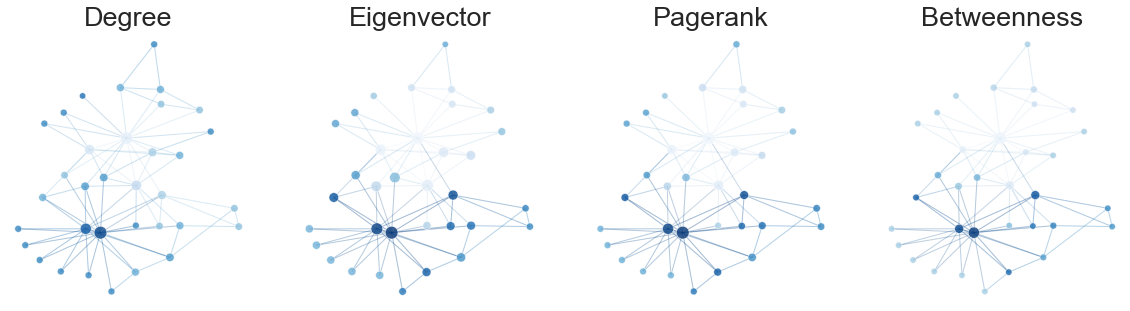

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
from graspologic.plot import networkplot
import seaborn as sns 

node_data = pd.DataFrame(index=g.nodes())
node_data['degree'] = node_data.index.map(dict(nx.degree(g)))
node_data['eigenvector'] = node_data.index.map(nx.eigenvector_centrality(g))
node_data['pagerank'] = node_data.index.map(nx.pagerank(g))
node_data['betweenness'] = node_data.index.map(nx.betweenness_centrality(g))

pos = nx.kamada_kawai_layout(g)
node_data['x'] = [pos[node][0] for node in node_data.index]
node_data['y'] = [pos[node][1] for node in node_data.index]

sns.set_context('talk', font_scale=1.5)
fig, axs = plt.subplots(1,4,figsize=(20,5))

def plot_node_scaled_network(A, node_data, key, ax):
    levels = np.unique(node_data[key])
    rank_mapper = dict(zip(levels, np.arange(len(levels))))
    node_data[f"{key}_ranked"] = node_data[key].map(rank_mapper)
    networkplot(A, node_data=node_data, x='x', y='y', ax=ax, edge_linewidth=1.0, node_size=key, node_hue=key, palette='Blues')
    ax.axis('off')
    ax.set_title(key.capitalize())

ax = axs[0]
plot_node_scaled_network(A, node_data, 'degree', ax)

ax = axs[1]
plot_node_scaled_network(A, node_data, 'eigenvector', ax)

ax = axs[2]
plot_node_scaled_network(A, node_data, 'pagerank', ax)

ax = axs[3]
plot_node_scaled_network(A, node_data, 'betweenness', ax)

fig.set_facecolor('w')

In [93]:
node_data

,degree,eigenvector,pagerank,betweenness,x,y,degree_ranked,eigenvector_ranked,pagerank_ranked,betweenness_ranked
0,16,0.355483,0.097002,0.437635,0.025953,0.332618,9,26,27,21
1,9,0.265954,0.052878,0.053937,-0.154154,0.251060,6,23,24,15
2,10,0.317189,0.057078,0.143657,0.072811,-0.003398,7,25,25,18
3,6,0.211174,0.035861,0.011909,0.151208,0.232506,5,20,22,7
4,3,0.075966,0.021979,0.000631,0.193135,0.574454,2,6,12,1
5,4,0.079481,0.029113,0.029987,0.189964,0.679017,3,7,18,12
6,4,0.079481,0.029113,0.029987,-0.004422,0.691958,3,7,17,11
7,4,0.170955,0.024491,0.000000,0.283520,0.210236,3,17,13,0
8,5,0.227405,0.029765,0.055927,-0.175658,-0.009901,4,22,20,16
9,2,0.102675,0.014309,0.000848,0.070613,-0.289252,1,11,1,2


## References 
```{bibliography}
:style: unsrt
```